# Dependencies
    1. pydicom: conda install -c conda-forge --no-deps pydicom
    2. pip install keras
    3. conda install scikit-image
    4. conda install scipy
    5. Demo_functions.py must be on path

# Introduction
This tutorial will give an example application of using deep learning for medical image segmentation. This example will demonstrate how to train a convolutional neural network for the purpose of lung segmentation in CT images. The tutorial will have 3 main parts:
1. Loading and preparing data for model training
2. Creating, training, and evaluating a deep learning segmentation model
3. Making improvements to the model with skip connections

## Initial preparation

These are some modules that we will definitely need throughout this example.

In [77]:
import os # operating system operations 
import numpy as np # number crunching
import keras # our deep learning library
%matplotlib notebook
import matplotlib.pyplot as plt # for plotting our results

We will import other necessary modules as we go and need them

## Data Preparation
All deep learning applications start with getting the data. In this case, the data has already been collected from subjects through CT scans and annotations have been made. 
Now that all the data is available, we need to load in this data in an organized way and get it ready to feed into a deep learning model for training.
This guide assumes that you have the data downloaded and extracted to the sub-directory 'LCTSC' in your working directory

### Directory setup

In [3]:
# First, let's get all the subject directories. We'll do this by proceeding
# through the directory structure and grabbing the ones we want.
# We'll use the package glob to make this easy
import glob
# We know our initial directory: LCTSC. Let's add that to our current
# directory to get the full path
initial_dir = os.path.join(os.getcwd(),'LCTSC')
# Now we'll get all the subject directories using glob
subj_dirs = glob.glob(os.path.join(initial_dir,'LCTSC*'))
# Now all the subject directories are contained in a list
# Let's grab the first one in that list and look for the data
cur_dir = subj_dirs[1]
# The next directory level just has 1 directory, so we'll grab that
cur_dir = glob.glob(os.path.join(cur_dir, "*", ""))[0]
# Now we have the dicom image directory and the label directory
# The dicom iamge directory starts with a 0 so we'll find that one first
dcm_dir = glob.glob(os.path.join(cur_dir, "0*", ""))[0]
# Let's grab the label directory while we're at it. It starts with a 1
lbl_dir = glob.glob(os.path.join(cur_dir, "1*", ""))[0]
# Now, we can get the list of dicom files that we need to 
# load for this subject
# We just have to look for .dcm files in the dcm_dir we found
dicom_files = glob.glob(os.path.join(dcm_dir, "*.dcm"))
# Great. Let's get the label filepath too
# It's just contained in a single dicom-rt file in the label directory
lbl_file = glob.glob(os.path.join(lbl_dir,"*.dcm"))[0]

Great! We have all the file paths for this subject. Now we need to actually load in the data

### Reading in images

In [4]:
# We'll need the PyDicom package to read the dicoms
import pydicom
# First, we'll load in all the dicom data to a list
dicms = [pydicom.read_file(fn) for fn in dicom_files]
# These likely won't be in slice order, so we'll need to sort them
# using the ImagePositionPatient header tag
dicms.sort(key = lambda x: float(x.ImagePositionPatient[2]))
# Then, stack all the pixel data together into a 3D array
# We'll convert the data from integers to floats while doing this
ims = np.stack([dcm.pixel_array.astype(np.float) for dcm in dicms])
# The last thing we will do is normalize all the images to [0,1]
# There are a variety of normalization methods used, but
# this is simple and seems to work just fine
for im in ims:
    im /= np.max(im)

### Reading in segmentation masks
We just loaded the input data for our deep learning model. Now we need to create the target masks that we want to train our model to output.

We want our output to be in the form of a binary mask- 1's where the pixels are part of the region of interest, and 0's where they are not.
Unfortunately, the data we have came from a segmentation program where it was stored as contours- the boundaries of the region of interest.

We will have to load in the contour data and convert it into the masks we need.

The data we have actually has contours for the heart, lungs, spine, and esophagus. For the purpose of this example, we will focus on the lungs.

In [5]:
# Let's go back and load the label file we already found
label = pydicom.read_file(lbl_file)
# First, get the contour data.
# We need to figure out which contours are the lungs
contour_names = [s.ROIName for s in label.StructureSetROISequence]
# Get the right and left lung indices
r_ind = contour_names.index('Lung_R')
l_ind = contour_names.index('Lung_L')
# Extract the corresponding contours and combine
contour_right = [s.ContourData for s in 
                 label.ROIContourSequence[r_ind].ContourSequence]
contour_left = [s.ContourData for s in 
                label.ROIContourSequence[l_ind].ContourSequence]
contours = contour_left + contour_right
# Next, we need to setup the coordinate system for our images
# to make sure our contours are aligned
# First, the z position
z = [d.ImagePositionPatient[2] for d in dicms]
# Now the rows and columns
# We need both the position of the origin and the
# spacing between voxels
pos_r = dicms[0].ImagePositionPatient[1]
spacing_r = dicms[0].PixelSpacing[1]
pos_c = dicms[0].ImagePositionPatient[0]
spacing_c = dicms[0].PixelSpacing[0]
# Now we are ready to create our mask
# First, preallocate an array of zeros
mask = np.zeros_like(ims)    
# we are going to need a contour-to-mask converter
from skimage.draw import polygon
# now loop over the different slices that each contour is on
for c in contours:
    nodes = np.array(c).reshape((-1, 3))
    assert np.amax(np.abs(np.diff(nodes[:, 2]))) == 0
    zNew = [round(elem,1) for elem in z]
    try:
        z_index = z.index(nodes[0,2])
    except ValueError:
        z_index = zNew.index(nodes[0,2])
    r = (nodes[:, 1] - pos_r) / spacing_r
    c = (nodes[:, 0] - pos_c) / spacing_c
    rr, cc = polygon(r, c)
    mask[z_index,rr, cc] = 1

### Now we have a mask!

We have all the pieces we need:
* Inputs
* Targets

...but just for the first subject out of ten. Now we just to repeat for all of the subjects.

Luckily, we have provided a pre-made function that does everything we just did in one move. All we have to do is call this function on each of the directories we already collected

In [6]:
# function for loading in input and target data given a directory
from Demo_Functions import GetLCTSCdata

Now, apply this function to each subject directory

In [7]:
data = [GetLCTSCdata(d) for d in subj_dirs]
# get all images together as inputs
inputs = np.concatenate([d[0] for d in data])
# get all masks together as targets
targets = np.concatenate([d[1] for d in data])
# clear a couple large variables that are no longer needed
del data

At this point, it would be good to check that our data loaded correctly and the masks correspond to the input images. We'll using the python plotting package matplotlib to display a sample image and mask side by side.

In [67]:
disp_ind = 50
plt.figure()
disp = np.c_[inputs[disp_ind,...],
             targets[disp_ind,...]]
plt.imshow(disp,cmap='gray')
plt.show()

NameError: name 'inputs' is not defined

### Final pre-processing

Just a couple more pre-processing steps.
First, our images are 512x512. That's pretty large for most deep learning applications. It's certainly doable, but for the purpose of this demonstration we will downsample to 256x256 so that the processing is faster.

We'll use another scipy function for this

In [8]:
from scipy.ndimage import zoom
inputs = zoom(inputs, (1,.5,.5))
targets = zoom(targets, (1,.5,.5))
targets[targets>.1] = 1
targets[targets<.1] = 0

The final step is to add a singleton dimesion to these arrays. This is necessary because the deep learning model we will create will expect our input to have color channels. Since our images are grayscale, they will just have a single color channel.

In [9]:
inputs = inputs[...,np.newaxis]
targets = targets[...,np.newaxis]

## Our data is now ready for training!

### Wait.

We don't just need training data. We need a way of determining if our model is overfitting. This means we need both training data and also another set of data to check the performance on data that is not being trained on. 

We can split some of our data off and use it for validation during the training process. Let's take 20% of the last slices and use them for this purpose. This will be equal to the last two subjects, so we won't have any overlap of subjects between the different sets

In [11]:
# Get the total number of slices
num_slices = inputs.shape[0]
# Find the cutoff
split_ind = np.int(.8*num_slices)
# split into training and validation using common nomenclature
x_train = inputs[:split_ind]
y_train = targets[:split_ind]
x_val = inputs[split_ind:]
y_val = targets[split_ind:]
# finally, shuffle the order of the training data
# being sure to keep the inputs and targets in the 
# same order...
sort_r = np.random.permutation(split_ind)
np.take(x_train,sort_r,axis=0,out=x_train)
np.take(y_train,sort_r,axis=0,out=y_train)
# clear up unneeded variables
del inputs,targets

### NOW, our data is ready!

## Building a segmentation network

We will build a deep convolutional neural network layer by layer, using Keras' high-level libraries that are relatively easy to work with to create exactly the networkt that we want.

In [12]:
# We first need an input layer that takes our inputs
from keras.layers import Input

Our input layer just needs the shape of the input we are providing. The shape dimensions are [sample,row,column,channel].

For this 2D network, our samples are different slices. We don't need to provide this dimension to the input layer, since we will feed those samples in as batches during training. But we need the rest of the dimensions

In [72]:
inp = Input(shape=x_train.shape[1:])

Now, we will add on convolutional layers

In [14]:
from keras.layers import Conv2D

The syntax for adding layers to our network is:

newlayer = LayerType(layer_parameters)(input_layer)

   newlayer: the variable that stores the current output of the network.  
   LayerType: the type of the new layer we are adding onto the network, in this case Conv2D layers.  
   layer_parameters: the inputs we provide to define the new layer. For Conv2D layers, this is given as (number of filters, size of filters, and type of nonlinearity applied to the layer).  
   input_layer: the previous layer that our new layer is going to be connected to.

In [98]:
x = Conv2D(10,(3,3),activation='relu')(inp)
# We can reuse the variable 'x' and Keras will remember what the layers
# are connected to
x = Conv2D(20,(3,3),activation='relu')(x)
x = Conv2D(30,(3,3),activation='relu')(x)
# now we will use a strided convolution, which downsamples the input
# and increases the network's receptive field
# We will use zero padding first to make the image shapes
# work out correctly
from keras.layers import ZeroPadding2D
x = ZeroPadding2D(padding=(1,1))(x)
x = Conv2D(40,(4,4),strides=(2,2),activation='relu')(x)
# repeat that sequence
x = Conv2D(50,(3,3),activation='relu')(x)
x = Conv2D(60,(3,3),activation='relu')(x)
x = Conv2D(70,(3,3),activation='relu')(x)
x = ZeroPadding2D(padding=(1,1))(x)
x = Conv2D(80,(4,4),strides=(2,2),activation='relu')(x)
# now, we will reverse the downsampling using Transposed Convolutions, also
# incorrectly but commonly called Deconvolution
from keras.layers import Conv2DTranspose
x = Conv2DTranspose(70,(3,3),activation='relu')(x)
x = Conv2DTranspose(60,(3,3),activation='relu',padding='same')(x)
x = Conv2DTranspose(50,(4,4),strides=(2,2),activation='relu')(x)
x = Conv2DTranspose(40,(3,3),activation='relu')(x)
x = Conv2DTranspose(30,(3,3),activation='relu',padding='same')(x)
x = Conv2DTranspose(20,(4,4),strides=(2,2),activation='relu')(x)
x = Conv2DTranspose(10,(3,3),activation='relu')(x)
# finally, our output layer will need to have a single output
# channel corresponding to a single segmentation class
# We will use sigmoid activation that squashed the output to a probability
out = Conv2D(1,(1,1),activation='sigmoid')(x)
# Now, we have a graph of layers created but they are not yet a model
# Fortunately, Keras makes it easy to make a model out of a graph
# just using the input and output layers
from keras.models import Model
SegModel = Model(inp,out)

We have a deep learning model created! Let's take a look to make sure we got the image shapes to work out:

In [ ]:
SegModel.summary()

### Compiling the model

Compiling the model is the final step before it is ready to train. We need to define our loss function and optimizer that Keras will use to run the training. In this step, Keras will also randomly initialize the weights of our network- so every time the network is trained, it has a different starting point and it is possible to get different results.

### Loss function
The Dice coefficient is not only a good segmentation metric, is also works well as a segmentation loss function since it can be converted to being differentiable without much difficulty. Loss functions in Keras need be defined using tensor functions, using the backend API.

Here is what that looks like:

In [17]:
import keras.backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + 1)/(K.sum(y_true_f) + K.sum(y_pred_f) + 1)
    # We have calculated dice, but we want to maximize it. 
    # Keras tries to minimize the loss so we simply return 1- dice
    return 1-dice

The ADAM optimizer is widely used with good performance on the majority of deep learning applications, so we'll use that. The learning rate will be set to a fairly standard value.

In [100]:
# opt = keras.optimizers.Adam()
# opt = keras.optimizers.Adagrad()
opt = keras.optimizers.Adadelta(clipnorm=1.)
# opt = keras.optimizers.SGD(lr=0.1,decay=1e-6,momentum=.9,nesterov=True,
#                           clipnorm=1.)
SegModel.compile(loss=dice_coef,optimizer=opt)

### Model Training
All that's left to do is to "fit" the model to our data! We supply our training data, our batch size and epochs that were defined earlier, we ask Keras to constantly report progress (verbose), and we supply some validation data that will be evaluated at the end of every epoch so we can keep an eye on overfitting

In [121]:
hist = SegModel.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          shuffle=True,
          validation_data=(x_val, y_val))

Train on 1154 samples, validate on 289 samples
Epoch 1/20
1154/1154 [==============================] - 11s 10ms/step - loss: 0.0360 - val_loss: 0.2982
Epoch 2/20
1154/1154 [==============================] - 11s 10ms/step - loss: 0.0356 - val_loss: 0.2647
Epoch 3/20
1154/1154 [==============================] - 11s 10ms/step - loss: 0.0332 - val_loss: 0.2443
Epoch 4/20
1154/1154 [==============================] - 11s 10ms/step - loss: 0.0311 - val_loss: 0.2581
Epoch 5/20
1154/1154 [==============================] - 11s 10ms/step - loss: 0.0293 - val_loss: 0.2401
Epoch 6/20
1154/1154 [==============================] - 11s 10ms/step - loss: 0.0328 - val_loss: 0.2667
Epoch 7/20
1154/1154 [==============================] - 11s 10ms/step - loss: 0.0294 - val_loss: 0.2467
Epoch 8/20
1154/1154 [==============================] - 11s 10ms/step - loss: 0.0279 - val_loss: 0.3096
Epoch 9/20
1154/1154 [==============================] - 11s 10ms/step - loss: 0.0287 - val_loss: 0.2387
Epoch 10/20
1154/

### Evaluate Model
After the training is complete, we evaluate the model again on our validation data to see the results.

In [122]:
score = SegModel.evaluate(x_val, y_val, verbose=0)
print('Final Dice on validation set: {:.04f}'.format(1-score))

Final Dice on validation set: 0.7696


Another way to evaluate a model is to look at how both the training and validation losses change during training. Keras gave us this data when we trained the model, now we can plot them together.

<IPython.core.display.Javascript object>


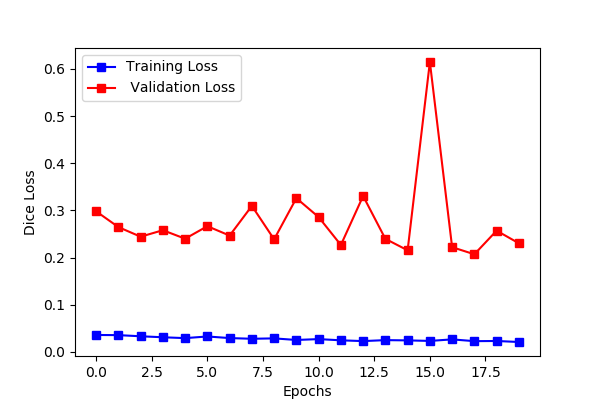

In [124]:
plt.figure(figsize=(6.0, 4.0));
plt.plot(hist.epoch,hist.history['loss'],'b-s')
plt.plot(hist.epoch,hist.history['val_loss'],'r-s')
plt.legend(['Training Loss',
            ' Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.show()

An important thing to look for is that the validation loss isn't increasing while the training loss decreases. The divergence of the losses like this means that the model is overfitting- it is getting really good at the training data that it sees, but it is getting worse at the data that it doesn't see. This means the model won't be very helpful when we want to apply it to new data.
Due to the random initialization of the network, the exact loss plots will be different every single time you train it. However, for this example, some general statements can be made that probably apply to your results.
* The validation and training losses generally go down. This is good- the model is learning.
* The validation loss is generally higher than the training loss. This is expected- the model will learn the training data best because that is what it gets direct feedback on. The hope is that it will transfer what it learns to the validation data too.
* The validation loss spikes up at some point. This is also pretty normal. The validation data isn't part of the feedback loop so it's not guaranteed that the model will consistently get better results on it. As long as the spikes are isolated and the validation loss follows a general downward trend, it's not anything to worry about.

Another useful way to evaluate a model is to just look at the outputs. We can look at a sample image to see how the mask looks compared to the ground truth.

<IPython.core.display.Javascript object>


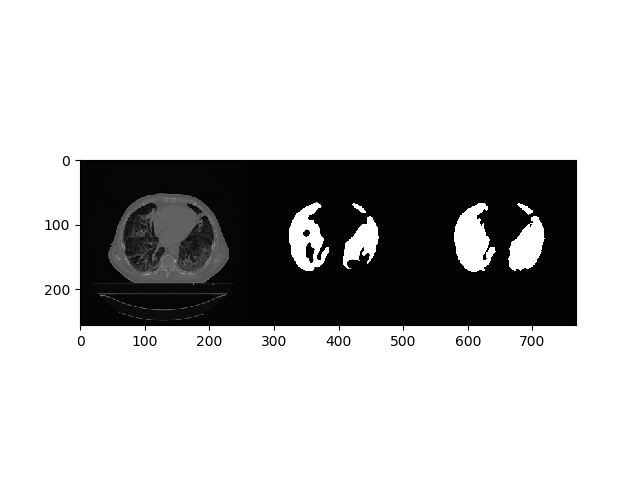

In [125]:
# We'll display the prediction and truth next to each other
# and see how it faired
predictions = SegModel.predict(x_val)
# pick a random slice to examine
disp_ind = 42
plt.figure()
disp = np.c_[x_val[disp_ind,...,0],
             predictions[disp_ind,...,0],
             y_val[disp_ind,...,0]]
plt.imshow(disp,cmap='gray')
plt.show()

Not bad! It's not a beautiful mask but the model definitely has learned something useful and can produce a somewhat reasonable result.

There are a variety of directions to go from here

A deeper net gives more representational power to the model. If the problem is too complex for the current network, making it deeper should improve performance.

Some mathematical tricks, like batch normalization and ELU activations can help with the learning process and make the model learn quicker.

Deep learning models are generally trained for much longer than how long we are running for this example.

In segmentation, a particularly useful trick is the use of skip connetions, in which layers from the downsampling part of the network are concatenated with layers on the upsampling part. This both boosts the representational power of the model as well as improves the gradient flow, which also helps the model learn quicker.
However, these skip connections take a little bit more effect to implement. Luckily, Keras still makes it pretty easy.

## Part 3: Functional API
So far, we've been making sequential models.
Basically, it means that our network
has a single, straight path, i.e.

![Simple CNN floatchart](https://github.com/jmj23/deep-learning/raw/master/BootCamp/CNN_simple_flowchart.png "Simple CNN")

Each layer has a single input and output

But what if we wanted something more complicated? What if
we wanted to implement the skip connections that were just mentioned, for example? Then we would want something like

![Connection CNN floatchart](https://github.com/jmj23/deep-learning/raw/master/BootCamp/CNN_connection_flowchart.png "Connection CNN")

               
The extra connection shown is called a skip connection. Skip connections allow the model to consider features that were calculated earlier in the network again, merged with further processed features in practice, this has shown to be hugely helpful in geting precise localization in segmentation outputs.

We'll use the same segmentation data so no need to prepare anything new. Let's jump into model creation.

## Build a segmentation model with skip connections

In [113]:
# A new layer we will need for this model
from keras.layers import concatenate

# start like before
inp = Input(shape=x_train.shape[1:])
# add on a couple convolutional layers
# We don't need to keep track of every layer- just
# a few of them. We won't keep track of the first one
# but we'll keep the second one and name it x1
x = Conv2D(20,kernel_size=(3,3),padding='same',activation='relu')(inp)
x1 = Conv2D(40, kernel_size=(3,3),padding='same',activation='relu')(x)
# Add zero padding like before to keep our layer sizes friendly
# and then perform downsampling
zp = ZeroPadding2D(padding=(1,1))(x1)
x = Conv2D(40, kernel_size=(4,4),
                 strides=(2,2),
                 activation='relu')(zp)
# Now repeat the process, hanging onto the second layer again
x = Conv2D(60, kernel_size=(3,3),padding='same',activation='relu')(x)
x2 = Conv2D(60, kernel_size=(3,3),padding='same',activation='relu')(x)
zp = ZeroPadding2D(padding=(1,1))(x2)
x = Conv2D(60, kernel_size=(4,4),
                strides=(2,2),
                activation='relu')(zp)
# We've now done 2 downsampling layers, like before.
# Now for the decoding side of the network, we will start
# adding skip connections
# The first couple of layers are the same as usual.
x = Conv2D(60, kernel_size=(3,3),padding='same',activation='relu')(x)
x = Conv2D(60, kernel_size=(3,3),padding='same',activation='relu')(x)
# Now our upsampling layer
x = Conv2DTranspose(60, kernel_size=(4,4),
                          strides=(2,2),
                          activation='relu')(x)
x = Conv2D(60, kernel_size=(3,3),activation='relu')(x)
# This layer is now the same size as the second layer we kept.
# It can be tough to get layers to match up just right in size
# Playing around with kernel size and strides is usually needed
# so that concatenation can take place. The x,y spatial dimensions
# must be the same. Number of channels doesn't matter.
# Luckily, we already did the work for you so these layers can be
# concatenated
x = concatenate([x,x2])
# Now continue to add layers for the decoding side of the
# network, treating this merged layer like any other
x = Conv2D(40, kernel_size=(3,3),padding='same',activation='relu')(x)
x = Conv2D(40, kernel_size=(3,3),padding='same',activation='relu')(x)
x = Conv2DTranspose(40, kernel_size=(4,4),
                          strides=(2,2),
                          activation='relu')(x)
x = Conv2D(40, kernel_size=(3,3),activation='relu')(x)
x = concatenate([x,x1])
x = Conv2D(20, kernel_size=(3,3),padding='same',activation='relu')(x)
x = Conv2D(20, kernel_size=(3,3),padding='same',activation='relu')(x)

# Final output layer
out = Conv2D(1,kernel_size=(1,1),activation='sigmoid')(x)

SegModel2 = Model(inp,out)

Let's print out a summary of the model to make sure it's what we want.
It's a little bit harder to keep track of layers in non-sequential format, but it's still a good way to make sure things look right.

In [ ]:
SegModel2.summary()

Now, everything else is just like the previous segmentation model. Let's try it out and see how it works!

In [114]:
# opt = keras.optimizers.Adam()
# opt = keras.optimizers.Adagrad()
opt = keras.optimizers.Adadelta(clipnorm=1.)
# opt = keras.optimizers.SGD(lr=0.1,decay=1e-6,momentum=.9,nesterov=True,
#                           clipnorm=1.)
SegModel2.compile(loss=dice_coef,optimizer=opt)

In [115]:
hist2 = SegModel2.fit(x_train, y_train,
          batch_size=32,
          epochs=10,
          verbose=1,
          shuffle=True,
          validation_data=(x_val, y_val))

Train on 1154 samples, validate on 289 samples
Epoch 1/10
1154/1154 [==============================] - 21s 18ms/step - loss: 0.9243 - val_loss: 0.9181
Epoch 2/10
1154/1154 [==============================] - 20s 17ms/step - loss: 0.9239 - val_loss: 0.9175
Epoch 3/10
1154/1154 [==============================] - 20s 17ms/step - loss: 0.9227 - val_loss: 0.9154
Epoch 4/10
1154/1154 [==============================] - 20s 17ms/step - loss: 0.9157 - val_loss: 0.8960
Epoch 5/10
1154/1154 [==============================] - 20s 17ms/step - loss: 0.8159 - val_loss: 0.8724
Epoch 6/10
1154/1154 [==============================] - 20s 17ms/step - loss: 0.5039 - val_loss: 0.9056
Epoch 7/10
1154/1154 [==============================] - 19s 16ms/step - loss: 0.3259 - val_loss: 0.4568
Epoch 8/10
1154/1154 [==============================] - 19s 16ms/step - loss: 0.2005 - val_loss: 0.3878
Epoch 9/10
1154/1154 [==============================] - 19s 16ms/step - loss: 0.1283 - val_loss: 0.3178
Epoch 10/10
1154/

<IPython.core.display.Javascript object>


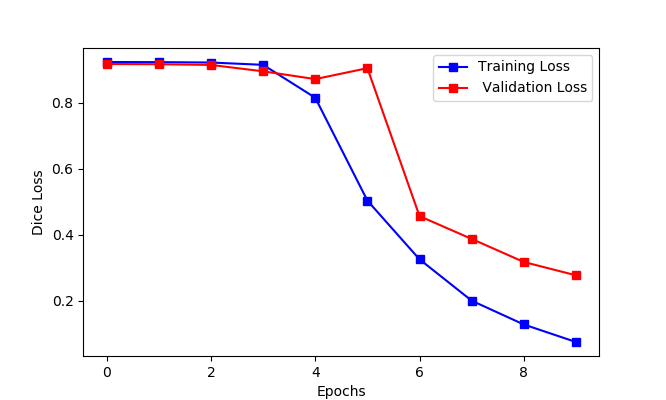

In [120]:
plt.figure(figsize=(6.0, 4.0));
plt.plot(hist2.epoch,hist2.history['loss'],'b-s')
plt.plot(hist2.epoch,hist2.history['val_loss'],'r-s')
plt.legend(['Training Loss',
            ' Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.show()

<IPython.core.display.Javascript object>


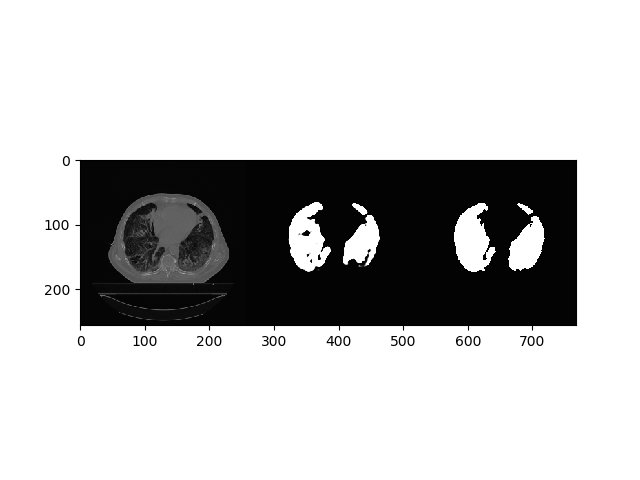

In [110]:
predictions = SegModel2.predict(x_val)
plt.figure()
disp_ind = 42
disp = np.c_[x_val[disp_ind,...,0],
             predictions[disp_ind,...,0],
             y_val[disp_ind,...,0]]
plt.imshow(disp,cmap='gray')
plt.show()

It's better! The network learned much faster and already has better results. Having these skip connections definitely make a difference. The difference becomes more pronounced for deeper networks (more layers) with more parameters and larger images.

Now that you know the functional API, you can make any graph you like, train it, and use it! Once you've mastered the syntax and conceptual understanding of how to connect layers, you are only limited by your imagination as far as what kind of network you can build.

# Happy deep learning!